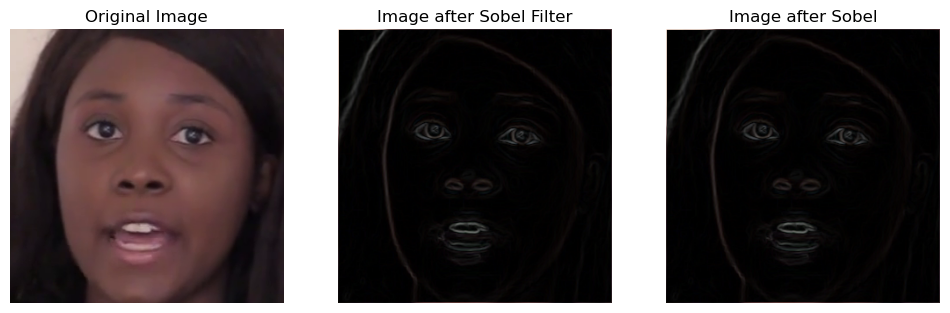

In [139]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

class SobelFilter(torch.nn.Module):
    def __init__(self):
        super(SobelFilter, self).__init__()
        self.sobel_kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.sobel_kernel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    def forward(self, img):
        channels = []
        for i in range(img.shape[0]):
            channel = img[i:i+1]
            sobel_x = torch.nn.functional.conv2d(channel.unsqueeze(0), self.sobel_kernel_x, padding=1)
            sobel_y = torch.nn.functional.conv2d(channel.unsqueeze(0), self.sobel_kernel_y, padding=1)
            sobel = torch.sqrt(sobel_x**2 + sobel_y**2)
            channels.append(sobel)
        sobel_3c = torch.cat(channels, dim=1)
        return sobel_3c.squeeze(0)
    

class Sobel(torch.nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.filter_x = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False, groups=3)
        self.filter_y = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False, groups=3)

        Gx = torch.tensor([[2.0, 0.0, -2.0], [4.0, 0.0, -4.0], [2.0, 0.0, -2.0]])
        Gy = torch.tensor([[2.0, 4.0, 2.0], [0.0, 0.0, 0.0], [-2.0, -4.0, -2.0]])
        
        Gx = Gx.expand(3, -1, -1).unsqueeze(1)
        Gy = Gy.expand(3, -1, -1).unsqueeze(1)
        
        self.filter_x.weight = torch.nn.Parameter(Gx, requires_grad=False)
        self.filter_y.weight = torch.nn.Parameter(Gy, requires_grad=False)

    def forward(self, img):
        sobel_x = self.filter_x(img)
        sobel_y = self.filter_y(img)
        sobel = torch.sqrt(sobel_x ** 2 + sobel_y ** 2)
        return sobel

def apply_sobel_filter(image_path):
    input_image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        SobelFilter(),
        transforms.Lambda(lambda x: x / x.max())
    ])
    
    transform2 = transforms.Compose([
        transforms.ToTensor(),
        Sobel(),
        transforms.Lambda(lambda x: x / x.max())
    ])
    transformed_image = transform(input_image)

    transformed_image2 = transform2(input_image)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(to_pil_image(transformed_image))
    plt.title('Image after Sobel Filter')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(to_pil_image(transformed_image2))
    plt.title('Image after Sobel')
    plt.axis('off')


    plt.show()


apply_sobel_filter('/home/eferreira/master/custom_vit/datasets/dfdc/train/faces/jjxwsknwdx_1809_1.png')


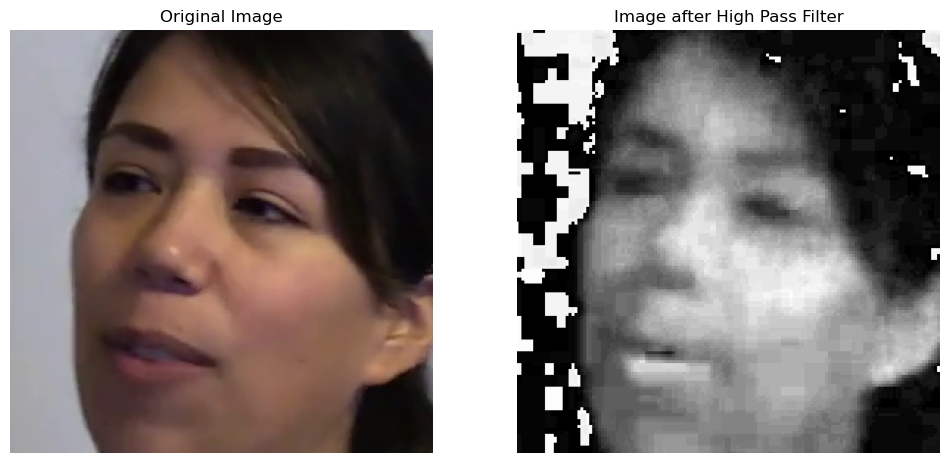

In [34]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

class HighPassFilter(nn.Module):
    def __init__(self):
        super(HighPassFilter, self).__init__()
        self.srm_filter = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=False)
        self.srm_filter.weight = nn.Parameter(self.get_srm_weights(), requires_grad=False)
        
    def get_srm_weights(self):
        weights = torch.tensor([
            [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
            [[0, 0, 0], [0, -1, 0], [0, 0, 0]],
            [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
        ]).float()
        weights = weights.unsqueeze(0).repeat(3, 1, 1, 1)
        return weights

    def forward(self, x):
        return self.srm_filter(x)

class HighPassFilterTransform:
    def __init__(self):
        self.high_pass_filter = HighPassFilter()
        
    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        img = img.unsqueeze(0)
        img = self.high_pass_filter(img)
        img = img.squeeze(0)
        return img

def apply_highpass_filter(image_path):
    input_image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        HighPassFilterTransform(),
        transforms.Lambda(lambda x: x / x.max())
    ])


    transformed_image = transform(input_image)
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(to_pil_image(transformed_image))
    plt.title('Image after High Pass Filter')
    plt.axis('off')

    plt.show()


apply_highpass_filter('/home/eferreira/master/custom_vit/datasets/dfdc/train/faces/kkmzagnxpn_61_1.png')


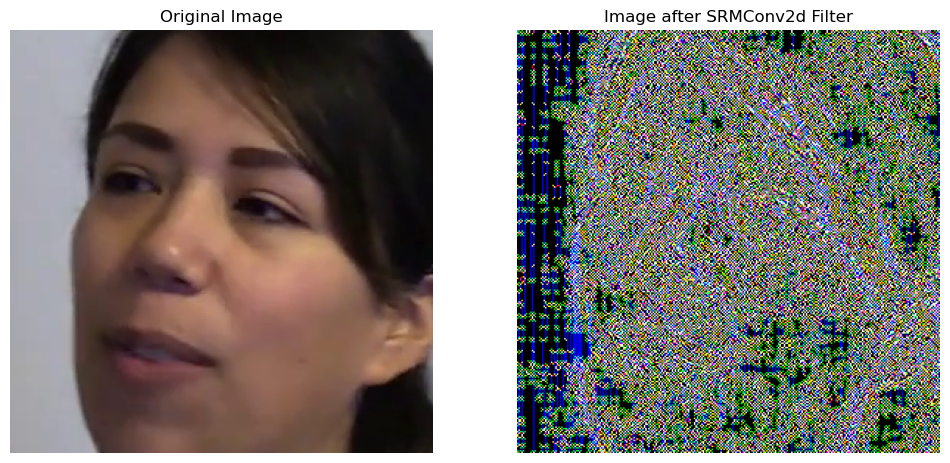

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

class SRMConv2d_simple(nn.Module):
    def __init__(self, inc=3, learnable=False):
        super(SRMConv2d_simple, self).__init__()
        self.truc = nn.Hardtanh(-3, 3)
        kernel = self._build_kernel(inc)  # (3,3,5,5)
        self.kernel = nn.Parameter(data=kernel, requires_grad=learnable)

    def forward(self, x):
        out = F.conv2d(x, self.kernel, stride=1, padding=2)
        out = self.truc(out)
        return out

    def _build_kernel(self, inc):
        filter1 = [[0, 0, 0, 0, 0],
                   [0, -1, 2, -1, 0],
                   [0, 2, -4, 2, 0],
                   [0, -1, 2, -1, 0],
                   [0, 0, 0, 0, 0]]
        filter2 = [[-1, 2, -2, 2, -1],
                   [2, -6, 8, -6, 2],
                   [-2, 8, -12, 8, -2],
                   [2, -6, 8, -6, 2],
                   [-1, 2, -2, 2, -1]]
        filter3 = [[0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 1, -2, 1, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0]]
        filter1 = np.asarray(filter1, dtype=float) / 4.
        filter2 = np.asarray(filter2, dtype=float) / 12.
        filter3 = np.asarray(filter3, dtype=float) / 2.
        filters = [
            [filter1],
                   [filter2],
                   [filter3]
                   ]
        filters = np.array(filters)
        filters = np.repeat(filters, inc, axis=1)
        filters = torch.FloatTensor(filters)
        return filters

class SRMConv2dTransform:
    def __init__(self):
        self.srm_conv2d = SRMConv2d_simple(inc=3)
        
    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = transforms.ToTensor()(img)
        img = img.unsqueeze(0)
        img = self.srm_conv2d(img)
        img = img.squeeze(0)
        return img

def apply_srmconv2d_filter(image_path):
    input_image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        SRMConv2dTransform(),
        transforms.Lambda(lambda x: x / x.max())
    ])


    transformed_image = transform(input_image)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(to_pil_image(transformed_image))
    plt.title('Image after SRMConv2d Filter')
    plt.axis('off')

    plt.show()


apply_srmconv2d_filter('/home/eferreira/master/custom_vit/datasets/dfdc/train/faces/kkmzagnxpn_61_1.png')
